# Selecionar variáveis para o KNN utilizando o Algoritmo Genético

Neste notebook exploramos os métodos de selelçao de variáveis utilizando uma busca genética.

Até agora utilizamos apenas os algoritmos e funções do [Scikitlearn](http://scikit-learn.org/), porém não existe otimização de variáveis utilizando busca genética por padrão no SkLearn. Então, recorremos à uma inteface entre o [DEAP](http://deap.readthedocs.io/en/master/) (Distributed Evolutionary Algorithms in Python) e SkLearn escrita por [Manuel Calzolari](https://github.com/manuel-calzolari/sklearn-genetic).

Para utilizar o DEAP com Anaconda antes é recomen instalar o pacote com o seguinte comando:

`conda install -c conda-forge deap`

### Carregar as bibliotécas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from genetic_selection import GeneticSelectionCV # https://github.com/manuel-calzolari/sklearn-genetic

### Carregar as bases de dados

Neste caso carregamos apenas as que obtiveram os melhores resultados na etapa de escolha de estratégias.

In [2]:
training_mean = pd.read_csv("data/training_mean.csv").set_index('sessionNo')
testing_mean = pd.read_csv("data/testing_mean.csv").set_index('sessionNo')

### Estimador previamente selecionado

In [3]:
estimator = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

## Funções auxiliares

### Separar um dataframe em um vetor de características e  um vetor de classe

In [4]:
def splitData(df):
    x = df.iloc[:, :-1]
    y = df['order']
    return x, y

### Calcular a acurácia do modelo, dados dataframes de treinamento e teste

In [5]:
def accEstimator(estimator, df_train, df_test):
    x_train, y_train = splitData(df_train)
    x_test, y_test = splitData(df_test)
    estimator.fit(x_train,y_train)
    return estimator.score(x_test, y_test)

### Realizar a busca genética

Retorna um vetor booleando utilizado para selecionar as variáveis na avaliação da acurácia

In [6]:
def geneticSearch(df, estimator, population, crossover, generations, mutation):
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values
    selector = GeneticSelectionCV(estimator,
                                  cv=3,
                                  verbose=0,
                                  scoring="accuracy",
                                  n_population=population,
                                  crossover_proba=crossover,
                                  mutation_proba=mutation,
                                  n_generations=generations,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.05,
                                  tournament_size=3,
                                  caching=True,
                                  n_jobs=-1)
    selector = selector.fit(X, y)
    return selector

### Montar um vetor de acurácias para as variáveis selecionadas

In [7]:
def makeAccsArray(selectors):
    accs = []
    maxi = 0.
    selected_variables = []
    
    for i in range(len(selectors)):
            df_train = training_mean.copy()
            df_test = testing_mean.copy()
            
            for j in range(len(training_mean.columns)-1):
                if(not selectors[i][j]):
                    del df_train[training_mean.columns[j]]
                    del df_test[training_mean.columns[j]]
                    
            acc = accEstimator(estimator, df_train, df_test)
            if acc > maxi:
                maxi = acc
                selected_variables = df_train.columns[:-1]
                
            accs.append(accEstimator(estimator, df_train, df_test))
    return accs, maxi, selected_variables

## Experimentos

### Variar a quantidade de gerações entre 5 e 40

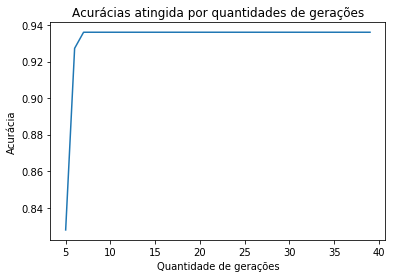

Maior acurácia: 0.936020348268
Variáveis selecionadas  Index(['cSumPrice', 'bCount', 'bStep', 'onlineStatus', 'availability'], dtype='object')


In [9]:
selectors = []
for generation in range(5, 40):
    selector = geneticSearch(training_mean,estimator, 300, 0.6, generation, 0.02)
    selectors.append(selector.support_)
    
accs, maxi, selected = makeAccsArray(selectors)

plt.plot(list(range(5, 40)),accs)
plt.xlabel('Quantidade de gerações')
plt.ylabel('Acurácia')
plt.title('Acurácias atingida por quantidades de gerações')
plt.show()
print('Maior acurácia: ' + str(maxi))
print('Variáveis selecionadas ', selected)